In [215]:
#-- Modules & Packages

import yfinance as yf 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

# import python_ta as ta
import ta as ta
from technical_features_indicators import moving_yngzng_estimator
from technical_features_indicators import kaufman_ad_movavg
from technical_features_indicators import kama_mkt_regime
from technical_features_indicators import vwap


from datetime import datetime
from datetime import date
from dateutil.relativedelta import relativedelta

Data Collecting.

In [216]:
ticker = ['XMR-USD']

#-- Collecting 3 years
start_date = date.today() + relativedelta(months = - 36)
end_date = date.today()

#-- 1D ohlcv data collection
df_asset = yf.download(ticker, start_date, end_date, interval = '1D')

#-- Dropping irrelevant columns
df_asset.drop(columns=['Adj Close'], axis = 1, inplace=True)

#-- Converting all column names to lowercase
df_asset.columns = [x.lower() for x in df_asset.columns ]

#-- Previewing
df_asset

[*********************100%***********************]  1 of 1 completed


,open,high,low,close,volume
Date,,,,,
2021-04-03,260.855255,269.823242,252.578796,260.888367,528312209
2021-04-04,260.795074,272.899750,247.760330,261.990326,602319017
2021-04-05,261.301819,271.322388,258.169800,263.922668,488580114
2021-04-06,264.400604,277.299835,260.649048,271.043091,575073239
2021-04-07,271.025635,280.197083,253.583130,257.742859,737672836
...,...,...,...,...,...
2024-03-29,135.064209,137.171021,129.656464,132.513489,49952151
2024-03-30,132.513489,133.548508,126.795479,129.121521,58881074
2024-03-31,129.121521,129.874725,127.474876,128.285767,41670191


Features & Indicators.

In [217]:
df_asset = kaufman_ad_movavg(df_asset, 'close', 5)
df_asset = kama_mkt_regime(df_asset, 'close', 5, 15)
df_asset = vwap(df_asset)

In [218]:
df_asset['next_candle'] = df_asset['close'].shift(-1)
df_asset['target'] = (df_asset['next_candle'] > df_asset['close']).astype(int)


In [219]:
df_asset

,open,high,low,close,volume,kama_5,kama_15,kama_diff,mkt_trend,volXclose,cum_vol,cum_volXclose,vwap,next_candle,target
Date,,,,,,,,,,,,,,,
2021-04-03,260.855255,269.823242,252.578796,260.888367,528312209,NaN,NaN,NaN,-1,1.378305e+11,528312209,1.425509e+11,269.823242,261.990326,1
2021-04-04,260.795074,272.899750,247.760330,261.990326,602319017,NaN,NaN,NaN,-1,1.578018e+11,1130631226,3.069236e+11,271.462184,263.922668,1
2021-04-05,261.301819,271.322388,258.169800,263.922668,488580114,NaN,NaN,NaN,-1,1.289474e+11,1619211340,4.394863e+11,271.420002,271.043091,1
2021-04-06,264.400604,277.299835,260.649048,271.043091,575073239,NaN,NaN,NaN,-1,1.558696e+11,2194284579,5.989541e+11,272.960976,257.742859,0
2021-04-07,271.025635,280.197083,253.583130,257.742859,737672836,257.742859,NaN,NaN,-1,1.901299e+11,2931957415,8.056478e+11,274.781561,269.996246,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-29,135.064209,137.171021,129.656464,132.513489,49952151,139.059816,141.309761,2.249945,1,6.619334e+09,174133412700,4.248678e+13,243.989834,129.121521,0
2024-03-30,132.513489,133.548508,126.795479,129.121521,58881074,136.581639,140.684158,4.102519,1,7.602814e+09,174192293774,4.249465e+13,243.952503,128.285767,0
2024-03-31,129.121521,129.874725,127.474876,128.285767,41670191,135.177409,140.134533,4.957123,1,5.345692e+09,174233963965,4.250006e+13,243.925219,123.135437,0


In [220]:
from sklearn.ensemble import RandomForestClassifier

#-- dropping nan rows to avoid issues with fit() function
df_asset.dropna(inplace = True)

model = RandomForestClassifier(n_estimators = 30, min_samples_split= 100, random_state= 1)
train_df = df_asset[:-200]
test_df = df_asset[-200:]


predictors = ['close', 'open', 'high', 'low','mkt_trend', 'kama_diff' ]
model.fit(train_df[predictors], train_df['target'])

RandomForestClassifier(min_samples_split=100, n_estimators=30, random_state=1)

In [221]:
from sklearn.metrics import precision_score

predictions = model.predict(test_df[predictors])
predictions = pd.Series(predictions, index = test_df.index)
precision_score(test_df['target'], predictions)

0.5596330275229358

<AxesSubplot: xlabel='Date'>

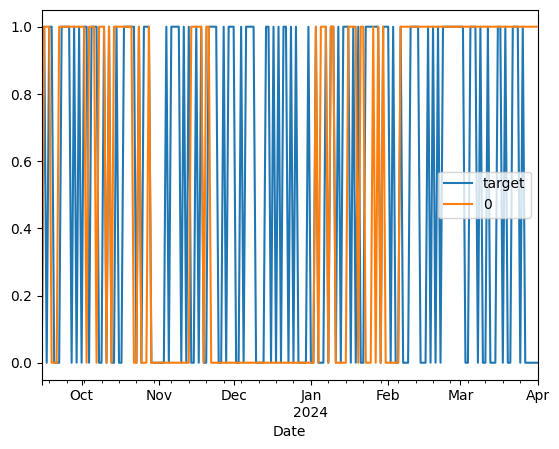

In [222]:
combined = pd.concat([test_df['target'], predictions], axis = 1)
combined.plot()

In [223]:
def predict(train_df, test_df, predictors, model):
    model.fit(train_df[predictors], train_df['target'])
    predictions = model.predict(test_df[predictors])
    predictions = pd.Series(predictions, index = test_df.index, name = "predictions")
    combined = pd.concat([test_df['target'], predictions], axis =1)
    return combined

def backtest(data, model, predictors, start = 90, step = 7):
    all_predictions = []
    for i in range(start, data.shape[0], step):
        train_df = data.iloc[0:i].copy()
        test_df = data.iloc[i:(i + step)].copy()
        predictions = predict(train_df, test_df, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)
    # return all_predictions

In [224]:
df_asset.head(3)

,open,high,low,close,volume,kama_5,kama_15,kama_diff,mkt_trend,volXclose,cum_vol,cum_volXclose,vwap,next_candle,target
Date,,,,,,,,,,,,,,,
2021-04-17,341.569061,378.572174,341.569061,367.498627,888937212,326.203570,367.498627,41.295057,1,3.266832e+11,9845286628,3.095621e+12,314.426656,337.785828,0
2021-04-18,367.769897,379.727570,292.784149,337.785828,1064304406,326.425459,364.946759,38.521300,1,3.595069e+11,10909591034,3.499766e+12,320.797202,355.632904,1
2021-04-19,338.248260,365.653839,307.654846,355.632904,1052097012,328.592639,363.983569,35.390931,1,3.741603e+11,11961688046,3.884470e+12,324.742593,401.207886,1


In [225]:
#-- dropping nan rows to avoid issues with backtest function
df_asset.dropna(inplace=True)

pred_x = ['close','mkt_trend','kama_5','kama_15']

predictions = backtest(df_asset, model, predictors=pred_x)

In [226]:
predictions

,target,predictions
Date,,
2021-07-16,1,1
2021-07-17,1,1
2021-07-18,0,1
2021-07-19,0,1
2021-07-20,1,1
...,...,...
2024-03-28,0,1
2024-03-29,0,1
2024-03-30,0,1


In [227]:
predictions['predictions'].value_counts()
precision_score(predictions['target'], predictions['predictions'])

0.5368852459016393

In [228]:
predictions['target'].value_counts() / predictions.shape[0]

1    0.535822
0    0.464178
Name: target, dtype: float64

In [229]:
# horizons = [3,7,60,365,730, 1000]
# new_predictors = []

horizons = [3,7,60,365]


for horizon in horizons:
    #-- set center = False to avoid look ahead leaks
    rolling_avg = df_asset.rolling(horizon, center=False).mean()
    ratio_column = f"closeprice_ratio_{horizon}"
    df_asset[ratio_column] = df_asset["close"] / rolling_avg['close']
    trend_column = f"trend_{horizon}"
    df_asset[trend_column] = df_asset.shift(1).rolling(horizon).sum()['target']

In [231]:
df_asset.dropna(inplace=True)

In [243]:
# pred_x = ['close','closeprice_ratio_3', 'trend_3',
#        'closeprice_ratio_7', 'trend_7', 'closeprice_ratio_60', 'trend_60',
#        'closeprice_ratio_365', 'trend_365', 'closeprice_ratio_730',
#        'trend_730']

# pred_x = ['close', 'trend_3','trend_7','trend_60','trend_365'] # better 2 % for XMR-USDT
pred_x = ['close', 'trend_3','trend_7','trend_60','trend_365','closeprice_ratio_3','closeprice_ratio_7','closeprice_ratio_60'] # better 3 % for XMR-USDT

predictions_b = backtest(df_asset, model, predictors=pred_x)

predictions_b['predictions'].value_counts()
precision_score(predictions_b['target'], predictions_b['predictions'])

print("After computing and adding moving averages to better catch trend, our model shows a precision score of:", round(100 * (precision_score(predictions_b['target'], predictions_b['predictions'])),2),"%.")


After computing and adding moving averages to better catch trend, our model shows a precision score of: 56.64 %.


Improved Model

In [250]:
model_b = RandomForestClassifier(n_estimators=200, min_samples_split=100, random_state=1)
# model_b = RandomForestClassifier(n_estimators=30, min_samples_split=100, random_state=1)

def predict_bis(train_df, test_df, predictors, model_b):
    model_b.fit(train_df[predictors], train_df["target"])
    preds = model_b.predict_proba(test_df[[predictors]])[:,1]
    preds[preds >=.6] = 1
    preds[preds < 0.6] = 0
    preds = pd.Series(preds, index = test_df.index, name = 'predicitions')
    combined = pd.concat([test_df['target'], preds], axis = 1)
    return combined


In [257]:


best_predictors = ['close', 'trend_3','trend_7','trend_60','trend_365','closeprice_ratio_3','closeprice_ratio_7','closeprice_ratio_60']

predictions_final = backtest(df_asset, model_b, best_predictors)

predictions_final['predictions'].value_counts()

[*********************100%***********************]  1 of 1 completed


In [ ]:
print("The improved model has a precision score of:", round(100 * (precision_score(predictions_final['target'], predictions_final['predictions'])),2),"%.")

The improved model has a precision score of: 57.5 %.
